# For Sample
[Convolutional Network Visualizations & Deep Dream](https://www.kaggle.com/code/carloalbertobarbano/convolutional-network-visualizations-deep-dream/notebook)

In [121]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms
import pathlib
import PIL
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import scipy.ndimage as ndimage

%matplotlib inline

import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO

In [127]:
MEAN_DEFINE = [0.485, 0.456, 0.406]
STD_DEFINE = [0.229, 0.224, 0.225]
IMAGE_RESIZE = (224, 224)

USE_GPU = False
DEFAULT_SAVE_IMAGE_FORMAT = 'jpeg'
WAIT = 0.01

SAVE_LAYER_DIR = 'layer'
SAVE_OUTPUT_DIR = 'output'

# ディレクトリを作成する

In [128]:
create_paths = [SAVE_LAYER_DIR, SAVE_OUTPUT_DIR]

for create_path in create_paths:
    pathlib.Path(create_path).mkdir(exist_ok=True) 

# np.uint8(np.clip(image, 0, 255))
* 0 ~ 255 の値に収め、uint8のnp型にキャストする

# バイト列を格納するBufferを用意する
* buffer = BytesIO()

In [98]:
def show_array(image, save_format=DEFAULT_SAVE_IMAGE_FORMAT):
    clip_np_image = np.uint8(np.clip(image, 0, 255))
    buffer = BytesIO()
    
    PIL.Image.fromarray(clip_np_image).save(buffer, save_format)
    display(Image(data=buffer.getvalue()))

# reshapeは配列を形状変換する
* mean(平均)
    * [0.485 0.456 0.406] -> [[[0.485 0.456 0.406]]]
* std(標準偏差)
    * [0.229, 0.224, 0.225] -> [[[0.229, 0.224, 0.225]]]
* inp(インプット)

In [99]:
def show_tensor(image):
    mean = np.array(MEAN_DEFINE).reshape([1, 1, 3])
    std = np.array(STD_DEFINE).reshape([1, 1, 3])

    # インプット
    inp = image[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255

    show_array(inp)
    clear_output(wait=True)

In [147]:
def plot_images(images, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(images)):
        plt.subplot(10 // 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(images[i])
        
    plt.pause(WAIT)

# Resize
* リサイズを行うTransform
# ToTensor
* PIL Image をテンソルに変換する Transform
* 値の範囲は [0, 1] の float にスケールされる
* 形状は (C, H, W) になる
# Normalize
* 正規化を行う Transform 
* n 個のチャンネルごとの平均 (m1,m2,⋯ ,mn),及び標準偏差 (s1,s2,⋯ ,sn) が与えられたとき、チャンネルごとに次のように標準化を行います。
$$ 
    output_c = \frac{input_c – m_c}s_c
$$

In [101]:
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_DEFINE, STD_DEFINE)
])

normalise_resize = transforms.Compose([
    transforms.Resize(IMAGE_RESIZE),
    transforms.ToTensor(),
    transforms.Normalize(MEAN_DEFINE, STD_DEFINE)
])

# np.full
* 任意の値で全要素を初期化したndarrayを生成する
* np.full(n, m, z) # n行 * m列 z次元

# numpy.random.uniform(low, high, size)
* 任意の範囲の連続一様分布から浮動小数点数の乱数を生成する

# torch.unsqueeze
* 指定した位置にサイズ1の次元を挿入する

In [102]:
def initialize_image(size=(400, 400, 3)):
    initalize_image = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    random_create_image = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    image_tensor = normalise(random_create_image).unsqueeze(0)
    image_np = image_tensor.numpy()
    return random_create_image, image_tensor, image_np

# PIL.Image.ANTIALIAS
* アンチエイリアスで写真をキレイに縮小


In [169]:
def load_image(path, resize=False, size=None):
    image = PIL.Image.open(path)
    
    if size is not None:
        image.thumbnail(size, PIL.Image.ANTIALIAS)
        
    if resize:
        image_tensor = normalise_resize(image).unsqueeze(0)
    else:
        image_tensor = normalise(image).unsqueeze(0)
    image_np = image_tensor.numpy()
    
    return image, image_tensor, image_np

In [104]:
def tensor_to_image(tensor):
    to_np = tensor.numpy()
    mean = np.array(MEAN_DEFINE).reshape([1, 1, 3])
    std = np.array(STD_DEFINE).reshape([1, 1, 3])
    inp = to_np[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

In [105]:
def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

# Model Creation
* Here we load a pretrained VGG-16 model

In [106]:
model = models.vgg16()
# TODO: ここが不明
# model.load_state_dict(torch.load('../input/vgg16/vgg16.pth'))

In [107]:
if torch.cuda.is_available():
    USE_GPU = True

print(model)

for param in model.parameters():
    param.requires_grad = False

if USE_GPU:
    print('Using CUDA')
    model.cuda()
else:
    print('Not using CUDA')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# TODO
* ここから疲れたので明日から理解します.............

In [108]:
def octaver_fn(model, base_image, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_image]
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        
        src = octave_base + detail
        
        for i in range(iter_n):
            src = step_fn(model, src, **step_args)

        detail = src.numpy() - octave_base

    return src

# フィルタの可視化
* この関数は、レイヤー layer_index の filter_index のフィルタの活性度を最大化する画像を生成する

In [109]:
def filter_step(model, img, layer_index, filter_index, step_size=5, display=True, use_L2=False):
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    model.zero_grad()
    
    img_var = image_to_variable(torch.Tensor(img), requires_grad=True, cuda=USE_GPU)
    optimizer = SGD([img_var], lr=step_size, weight_decay=1e-4)
    
    x = img_var
    for index, layer in enumerate(model.features):
        x = layer(x)
        if index == layer_index:
            break

    output = x[0, filter_index]
    loss = output.norm() #torch.mean(output)
    loss.backward()
    
    if use_L2:
        #L2 normalization on gradients
        mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2) + 1e-5])
        if USE_GPU:
            mean_square = mean_square.cuda()
        img_var.grad.data /= torch.sqrt(mean_square)
        img_var.data.add_(img_var.grad.data * step_size)
    else:
        optimizer.step()
    
    result = img_var.data.cpu().numpy()
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    
    if display:
        show_tensor(result)
    
    return torch.Tensor(result)

In [110]:
def visualize_filter(model, base_image, layer_index, filter_index, 
                     octave_n=6, octave_scale=1.4, iter_n=10, 
                     step_size=5, display=True, use_L2=False):
    
    return octaver_fn(
                model, base_image, step_fn=filter_step, 
                octave_n=octave_n, octave_scale=octave_scale, 
                iter_n=iter_n, layer_index=layer_index, 
                filter_index=filter_index, step_size=step_size, 
                display=display, use_L2=use_L2
            )

# 次に、与えられたレイヤーのフィルタの数を視覚化するヘルパー関数を定義する

In [153]:
def show_layer(layer_num, filter_start=10, filter_end=20,
               step_size=7, use_L2=False):
    filters = []
    titles = []
    
    _, _, img_np = initialize_image(size=(600, 600, 3))
    for i in range(filter_start, filter_end):
        title = (f'Layer{layer_num}_Filter_{i}')
        print(title)
        filter = visualize_filter(model, img_np, layer_num, 
                                  filter_index=i, octave_n=2, iter_n=20, 
                                  step_size=step_size, display=True, use_L2=use_L2)
        filter_img = tensor_to_image(filter)
        filter_img.save(f'{SAVE_LAYER_DIR}/{title}.{DEFAULT_SAVE_IMAGE_FORMAT}')
        filters.append(tensor_to_image(filter))
        titles.append(title)
    
    plot_images(filters, titles)
    return filters, titles

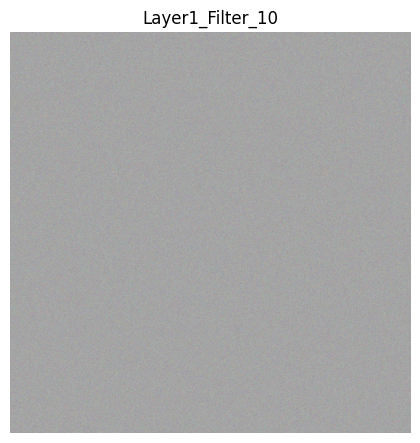

In [156]:
is_show_layer = 1
images, titles = show_layer(is_show_layer, use_L2=True, step_size=0.05)

# DeepDream

DeepDreamは、フィルタの可視化と似ていますが、ランダムなノイズ画像から始めるのではなく、実際の画像から始めて、ネットワークの出力を最大化しようとする機能
この方法では、ネットワークが画像から認識する特徴を強化することになる。低いレイヤーは幾何学的なパターンやテクスチャを生成する傾向があり、高いレイヤーはネットワークが学習過程で見たものに似た、より抽象的な形状を生成する傾向がある

実際のコードは、cafeで動作する[Google DeepDream](https://github.com/google/deepdream)のリポジトリからpytorchに移植されている

In [157]:
def objective(dst, guide_features):
    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
        return diff

In [174]:
def make_step(model, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    mean = np.array(MEAN_DEFINE).reshape([3, 1, 1])
    std = np.array(STD_DEFINE).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    img_var = image_to_variable(tensor, requires_grad=True, cuda=USE_GPU)
    model.zero_grad()
      
    x = img_var
    for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end:
            break
    
    delta = objective(x, control)
    x.backward(delta)
    
    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    if USE_GPU:
        mean_square = mean_square.cuda()
    img_var.grad.data /= torch.sqrt(mean_square)
    img_var.data.add_(img_var.grad.data * step_size)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    show_tensor(result)
    
    return torch.Tensor(result)

In [161]:
def deepdream(model, base_img, octave_n=6, octave_scale=1.4, 
              iter_n=10, end=28, control=None, objective=objective, 
              step_size=1.5, jitter=32):
    
    return octaver_fn(
              model, base_img, step_fn=make_step, 
              octave_n=octave_n, octave_scale=octave_scale, 
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

(1654, 2048)


/tmp/ipykernel_353/234926331.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image.thumbnail(size, PIL.Image.ANTIALIAS)


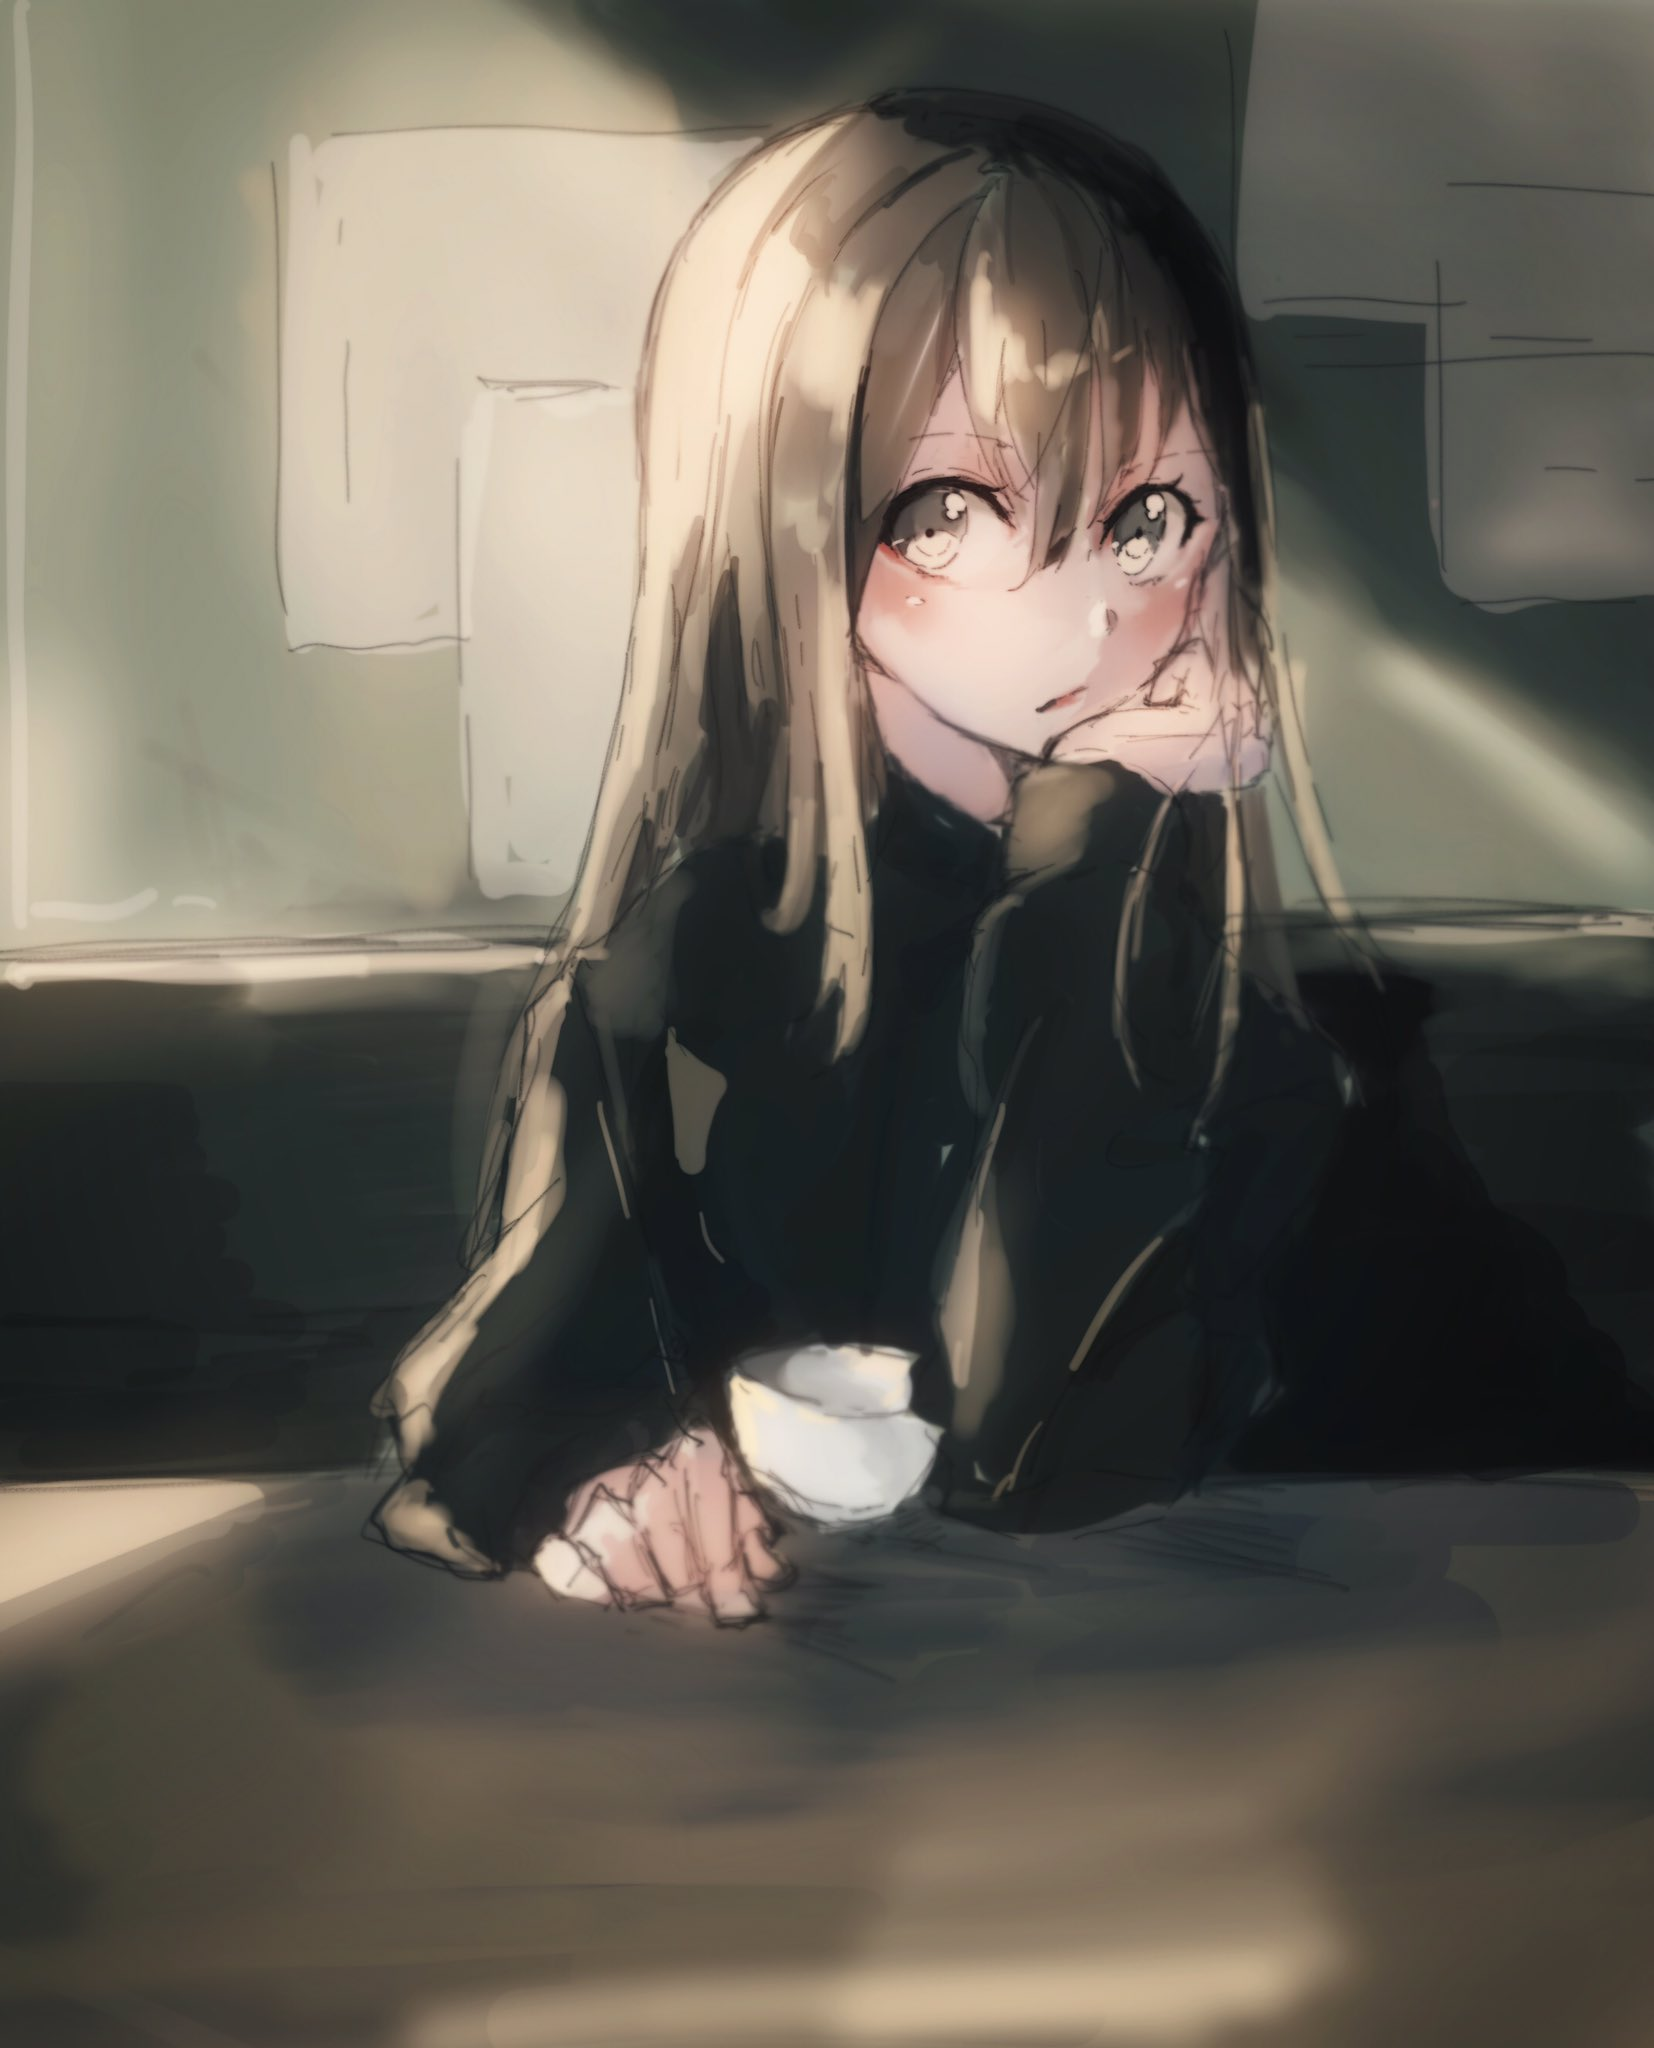

In [171]:
input_img, input_tensor, input_np = load_image('./input/input.jpg', size=[1654, 2048])
print(input_img.size)
input_img

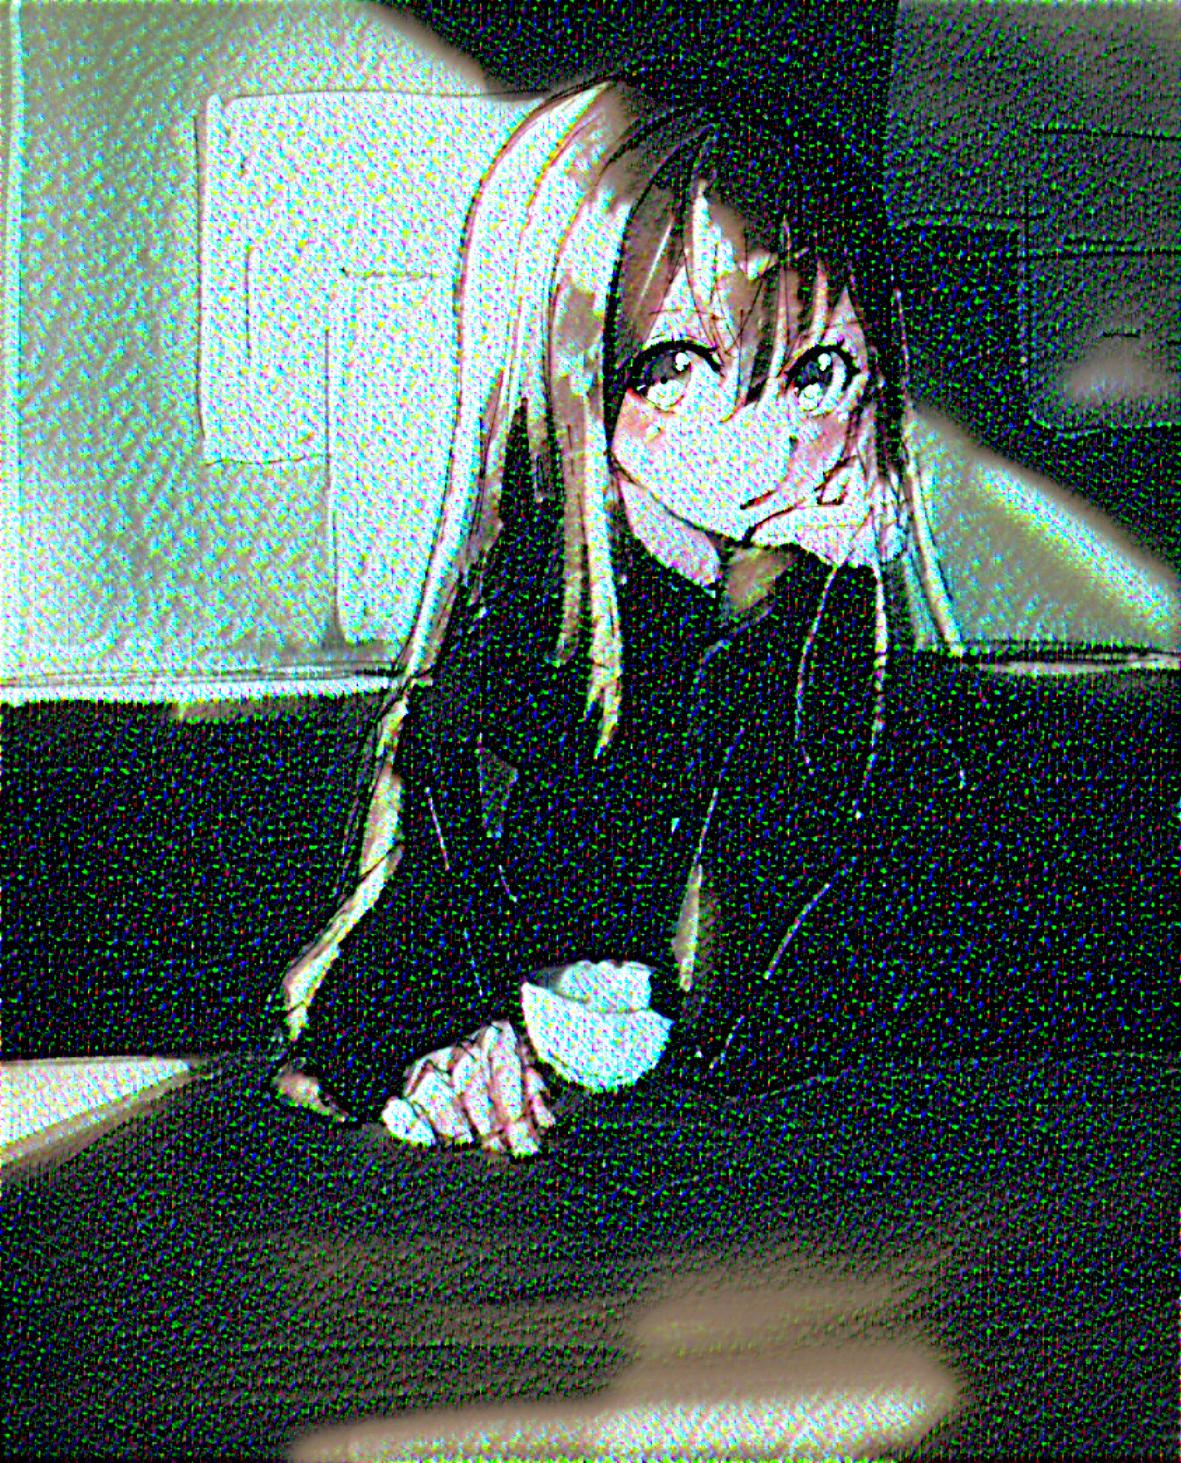

In [ ]:
dream = deepdream(model, input_np, end=14, step_size=0.06, octave_n=6)
dream = tensor_to_image(dream)
dream.save(f'{SAVE_OUTPUT_DIR}/{dream00.jpg}')
dream